In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

# for stats
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

# ML
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [2]:
data = pd.read_csv('blindedData_old.csv') # import the data from csv

In [3]:
data.shape # raw data shape

(21480, 135)

In [4]:
data.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,targetLabels
0,63.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,0.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,113.0,90.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
3,26.0,59.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,NaN,28.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


First order of business is to determine if there are columns that have all zero values. 

In [5]:
test = data.loc[:,(data == 0).all()].columns # columns that have all zero values, no data
print('Columns with all 0 data: ', test.tolist()) # can be removed from the dataset

Columns with all 0 data:  ['var_87', 'var_88', 'var_89', 'var_90', 'var_91', 'var_92']


In [6]:
data = data.loc[:,~(data == 0).all()] # remove columns with all zero values 

In [7]:
data.shape # removed all zero columns

(21480, 129)

Want to test if there are still columns that contain all zero and NaN values. 

In [8]:
nanTest = data.fillna(0) # this is on top of dataframe that already had all zero cols removed 
len(nanTest.loc[:,(nanTest == 0).all()].columns) 

0

The code above did not find any additional columns that registered as all 0 values after replacing NaN with 0. This means there are no columns that only contain NaN and 0 values. 

Need to determine if data points, each column, are categorical or numerical datapoints. Strategy is to find whether each column only contains a subset of whole numbers, 1 and 0s, this would indicate that it is categorical. 

In [9]:
data['var_125'].value_counts() # this is an example of likely categorical data, converted to numbers through feature engineering

0.0    20459
1.0      543
Name: var_125, dtype: int64

In [10]:
dtypeDict = {}
for col in data.columns:
    if col != 'targetLabels':
        if data[col].nunique() == 2:
            dtypeDict[col] = 'cat'
        else:
            dtypeDict[col] = 'num'

The benefit of the dict is that its searchable so I can only pull the variables that I need and dont need to make a list of equal len to the variables that are being analyzed. 

In [11]:
catOccur = 0
for k,v in dtypeDict.items():
    if v == 'cat':
        catOccur += 1
catOccur

96

In [12]:
print('pct of dataset that is categorical: ' + str(round(catOccur / (len(data.columns)-1),3)))

pct of dataset that is categorical: 0.75


If a data column is categorical then chi square test will be used for hypothesis testing. if a data column is numerical, then one-sided ANOVA will be used for hypothesis testing. 

In [13]:
""" def the stats tests """

def chi_square(x,y): # compares two categorical datatypes, also finds Cramer's V which measure variance (higher better)
    cont_table = pd.crosstab(index=data[x], columns=data[y])
    chi2_test = scipy.stats.chi2_contingency(cont_table)
    chi2, p = chi2_test[0], chi2_test[1]
    n = cont_table.sum().sum()
    phi2 = chi2/n
    r,k = cont_table.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
    coeff, p = round(coeff, 3), round(p, 3)
    return coeff,p # coeff is cramer, p is the p value

def anova(num,cat): # note this is one-way anova for comparing cat and num data 
    model = smf.ols(num+' ~ '+cat, data=data).fit()
    table = sm.stats.anova_lm(model)
    p = table["PR(>F)"][0]
    p = round(p, 3)
    return p # p is the p value
    

Below are two examples of the statistics hypothesis testing functions being called. 

In [14]:
testCeof, testP = chi_square('var_125','targetLabels') # Cramer of close to 0 indicates little association, p-value also shown signficance 
if testP < 0.05:
    sig = 'statistically significant p-value'
print('CramerV:',testCeof,'P-Value:',testP,'--',sig)

CramerV: 0.024 P-Value: 0.0 -- statistically significant p-value


In [15]:
testP = anova('var_1','targetLabels') # this just shows how anova works, var_1 is num and targetLabels is cat
if testP < 0.05:
    sig = 'statistically significant p-value'
print('One-way ANOVA P-Value:',testP,'--',sig) 

One-way ANOVA P-Value: 0.029 -- statistically significant p-value


In [16]:
results = {}
for col in data.columns:
    if col != 'targetLabels':
        if dtypeDict[col] == 'cat':
            cramer,p = chi_square(col,'targetLabels')
            results[col] = {'dtype':'cat','Anova-P':np.nan,'Chi2-P':p,'CramerV':cramer}
        if dtypeDict[col] == 'num':
            p = anova(col,'targetLabels')
            results[col] = {'dtype':'num','Anova-P':p,'Chi2-P':np.nan,'CramerV':np.nan}

statsRes = pd.DataFrame.from_dict(results)

In [17]:
statsRes = statsRes.transpose()
statsRes.head() # this is a trasposed dataframe containing the output from the code above

,dtype,Anova-P,Chi2-P,CramerV
var_0,num,0,NaN,NaN
var_1,num,0.029,NaN,NaN
var_2,num,0,NaN,NaN
var_3,cat,NaN,0.166,0.007
var_4,cat,NaN,0.144,0.007


In [18]:
statsRes.shape # does not contain the targetLabels col, thats why its 128 instead of 129

(128, 4)

In [19]:
statsRes['Stat-sig'] = np.where((statsRes['Anova-P'] < 0.05) | (statsRes['Chi2-P'] < 0.05),1,0) # adds stat sig column, '|' is or boolean

In [20]:
statsRes.head()

,dtype,Anova-P,Chi2-P,CramerV,Stat-sig
var_0,num,0,NaN,NaN,1
var_1,num,0.029,NaN,NaN,1
var_2,num,0,NaN,NaN,1
var_3,cat,NaN,0.166,0.007,0
var_4,cat,NaN,0.144,0.007,0


In [21]:
print('Pct of columns that are stat sig: ' +str(round(statsRes['Stat-sig'].sum() / len(statsRes['Stat-sig']),3)))

Pct of columns that are stat sig: 0.703


In [22]:
statsRes.dtypes

dtype       object
Anova-P     object
Chi2-P      object
CramerV     object
Stat-sig     int32
dtype: object

In [23]:
statsRes.astype({'CramerV':'Float32'}).nlargest(10,'CramerV')

,dtype,Anova-P,Chi2-P,CramerV,Stat-sig
var_45,cat,NaN,0,0.139,1
var_133,cat,NaN,0,0.116,1
var_49,cat,NaN,0,0.112,1
var_52,cat,NaN,0,0.111,1
var_62,cat,NaN,0,0.094,1
var_44,cat,NaN,0,0.092,1
var_59,cat,NaN,0,0.077,1
var_47,cat,NaN,0,0.075,1
var_43,cat,NaN,0,0.074,1
var_38,cat,NaN,0,0.072,1


Above are the 10 highest Cramer V values in the dataset. These are cat dtypes, Cramer V represents how correlated the col is to the targetLabels column. Thus, it shows which columns play the greatest role in predicting an outcome for the categorical subset of the data. 

In [24]:
statSig = statsRes.loc[statsRes['Stat-sig'] == 1]

In [25]:
statSig.astype({'CramerV':'Float32'}).nsmallest(10,'CramerV')

,dtype,Anova-P,Chi2-P,CramerV,Stat-sig
var_13,cat,NaN,0.027,0.014,1
var_31,cat,NaN,0.011,0.016,1
var_108,cat,NaN,0.01,0.016,1
var_118,cat,NaN,0.031,0.016,1
var_23,cat,NaN,0.006,0.017,1
var_12,cat,NaN,0.004,0.018,1
var_28,cat,NaN,0.003,0.019,1
var_10,cat,NaN,0.001,0.021,1
var_21,cat,NaN,0.002,0.021,1
var_22,cat,NaN,0.002,0.021,1


The dataframe above shows the lowest Cramer V values where the p-value is still significant. 

In [26]:
statSig['CramerV'].mean().round(decimals=3) # mean of CramerV values is generally low 

0.041

In [27]:
statSigCols = statSig.index.tolist() # convert index (col names) of the statSig variable to parse total dataset 
statSigCols = statSigCols + ['targetLabels'] # adds targetLabels to end of list so its included in dataset 

In [28]:
data.shape # 129 cols before 

(21480, 129)

In [29]:
statSigData = data[statSigCols] # new df with only stat sig columns 

In [30]:
statSigData.shape # this is only the data that was stat sig, more columns that stat sig variables because targetLabels included 

(21480, 91)

The next step is likely to partition the data into training and testing data. I am going to use a 0.7:0.3 training to testing ratio. Important to note that NaN values need to be filled, this should be done after the data has been partitioned to avoid using the mean of any testing data. For categorical data (cat), NaN values will be replaced with 0 as a mean does not make sense. Numerical (num) data NaN will be replaced with the mean of the column.  

In [31]:
pctNan = pd.DataFrame((statSigData.isna().sum() / len(statSigData)),columns=['PctTotal']) # finds pct of total col that is NaN 
pctNan = pctNan.loc[pctNan['PctTotal'] > 0.2] # only care if NaN makes up greater than 0.2 pct of values

In [32]:
sns.set_theme() # sets seaborn graphing theme

<AxesSubplot:ylabel='PctTotal'>

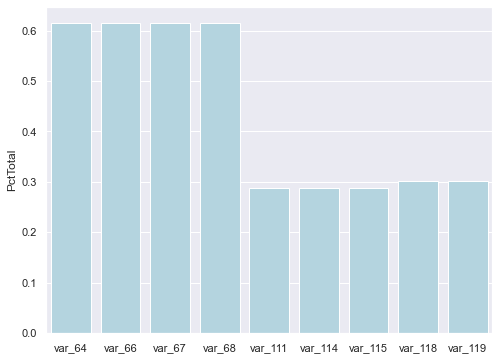

In [33]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=pctNan,x=pctNan.index,y='PctTotal',color='lightblue') # graph of pct 

In [34]:
statSig.loc[pctNan.index.to_list()] # more info on the columns that had more than 0.2 pct of total as NaN values

,dtype,Anova-P,Chi2-P,CramerV,Stat-sig
var_64,cat,NaN,0.001,0.034,1
var_66,cat,NaN,0.001,0.034,1
var_67,cat,NaN,0.011,0.026,1
var_68,cat,NaN,0,0.051,1
var_111,cat,NaN,0.005,0.021,1
var_114,cat,NaN,0,0.051,1
var_115,cat,NaN,0,0.035,1
var_118,cat,NaN,0.031,0.016,1
var_119,cat,NaN,0,0.045,1


In [35]:
print('Mean of Stat Sig CramerV:',statSig['CramerV'].mean().round(decimals=3))
print('Max of Stat Sig CramerV:',statSig['CramerV'].max().round(decimals=3))

Mean of Stat Sig CramerV: 0.041
Max of Stat Sig CramerV: 0.139


Columns that have NaN for greater than 0.2 pct of their total dataset have CramerV values that are close to the mean for the stat sig partition of the dataset. They are also stat-sig. The most concern should be focused on var_64,var_66,var_67, and var_68 as they have the highest percentage of NaN values (0.60). These values have CramerV values that are close to the mean. For these reasons, because it appears that what data is present is predictive, I am going to leave them in the dataset and just replace the NaN values with 0. 

In [36]:
trainingData,testingData = statSigData[:int(round(len(statSigData.index) * 0.7,0))],statSigData[int(round(len(statSigData.index) * 0.7,0)):] # partition the dataset into 0.7 training data and 0.3 testing data 
print('shape training data:', trainingData.shape)
print('shape testing data:', testingData.shape)

shape training data: (15036, 91)
shape testing data: (6444, 91)


As previously discussed the num and cat datatypes have NaN values that need to be replaced with different things. 0 or mean of column for cat and num specifically. The datatypes cat and num need to be generated again on the stat sig dataset, the list generated earlier is for the entire var list. The same methodology is used as earlier. 

In [37]:
trainDtypes = [] # record dtype as either cat or num based on unique values in training data 
for col in trainingData:
    if col != 'targetLabels':
        if trainingData[col].nunique() == 2: # categorical only contains 1s and 0s, ignores NaN values
            trainDtypes.append('cat')
        else:
            trainDtypes.append('num')

testDtypes = [] # record dtype as either cat or num based on unique values in testing data 
for col in testingData:
    if col != 'targetLabels':
        if testingData[col].nunique() == 2: # categorical only contains 1s and 0s, ignores NaN values
            testDtypes.append('cat')
        else:
            testDtypes.append('num')


In [38]:
for col in trainingData:
    if col != 'targetLabels':
        if dtypeDict[col] == 'cat':
            trainingData[col] = trainingData[col].fillna(0) # replace NaN with 0
        if dtypeDict[col] == 'num':
            trainingData[col] = trainingData[col].fillna(trainingData[col].mean()) # replace NaN with mean of column

for col in testingData:
    if col != 'targetLabels':
        if dtypeDict[col] == 'cat':
            testingData[col] = testingData[col].fillna(0) # replace NaN with 0
        if dtypeDict[col] == 'num':
            testingData[col] = testingData[col].fillna(testingData[col].mean()) # replace NaN with mean of column


In [39]:
[print(a) for a in trainingData.isna().sum().to_list() if a != 0] # verify all NaN values removed from training data

[]

In [40]:
[print(a) for a in testingData.isna().sum().to_list() if a != 0] # verify all NaN values removed from testing data

[]

The empty lists above indicate that all NaN values were successfully removed and replaced with either 0 or the mean of the column. There are still a lot of var or features in the dataset; the importance of these can be tested using random forests. The importance or predictive ability of each feature is computed based on how much it reduces entropy. 

In [41]:
from sklearn import ensemble

In [42]:
X = trainingData.drop("targetLabels", axis=1).values
y = trainingData["targetLabels"].values
feature_names = trainingData.drop("targetLabels", axis=1).columns.tolist() # var names w/o targetLabels

model = ensemble.RandomForestClassifier(n_estimators=100, # set up model
                      criterion="entropy", random_state=0)
model.fit(X,y) # run models
importances = model.feature_importances_ # pull how important 

importDf = pd.DataFrame({"importance":importances, # add to df 
            "variable":feature_names})
importDf = importDf.set_index("variable") # set variable as index 

In [43]:
importDf.dtypes

importance    float64
dtype: object

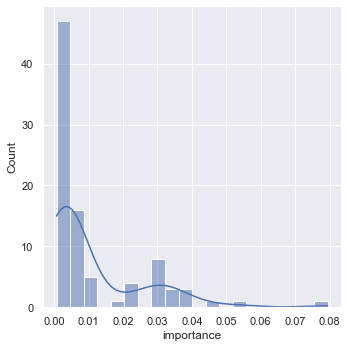

In [44]:
sns.displot(data=importDf,x='importance',kde=True) # this indicates that most of the variables are not that predictive 

The graph above of the 'importance' data generated using reducing of random forests entropy indicates that there are many variables that are not very predictive. Note, all the variables included in this final analysis were shown to be stat sig but that does not necessarily denote that the particular variable will be extremely predictive. 

In [45]:
importDf.nlargest(10,'importance') # 10 highest scoring variables

,importance
variable,
var_0,0.079477
var_103,0.054480
var_1,0.045453
var_100,0.038783
var_101,0.038727
var_102,0.038260
var_2,0.033717
var_70,0.032434
var_85,0.032269


The dataframe above shows the 10 largest variables based on importance. Most of the values in the dataset as a whole were from 0 to 0.06 as demonstrated by the graph. For the purpose of keeping some of the original variables, the top ten importance variables will be used in the final model. 

In [46]:
finalVar = importDf.nlargest(10,'importance').index.tolist() # pulls 10 highest scoring variables 

# training data 
xTrain = trainingData[finalVar].values 
yTrain = trainingData['targetLabels'].values

# testing data 
xTest = testingData[finalVar].values
yTest = testingData['targetLabels'].values

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier() # gradient boosting classifier model
clf.fit(xTrain,yTrain) # train model
predictions = clf.predict(xTest)
print(classification_report(yTest,predictions))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      4344
           1       0.55      0.50      0.53      2100

    accuracy                           0.70      6444
   macro avg       0.66      0.65      0.66      6444
weighted avg       0.70      0.70      0.70      6444



This shows 70% accuracy using these features and this model. Below is a different gradient boosted module. 

In [48]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(xTrain,yTrain)
predictions = clf.predict(xTest)

print(classification_report(yTest,predictions))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      4344
           1       0.50      0.24      0.32      2100

    accuracy                           0.68      6444
   macro avg       0.61      0.56      0.56      6444
weighted avg       0.64      0.68      0.64      6444



The logistic regression model produced accuracy of 0.68 percent. 

In [49]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = KNeighborsClassifier()
neighbors.fit(xTrain,yTrain)
predictions = neighbors.predict(xTest)

print(classification_report(yTest,predictions))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4344
           1       0.45      0.45      0.45      2100

    accuracy                           0.64      6444
   macro avg       0.59      0.59      0.59      6444
weighted avg       0.64      0.64      0.64      6444



Nearest neighbors generated accuracy of 0.64. 

In [50]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(xTrain,yTrain)
predictions = clf.predict(xTest)

print(classification_report(yTest,predictions)) # this is basically the same as the gradient boosted algo

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      4344
           1       0.54      0.46      0.50      2100

    accuracy                           0.70      6444
   macro avg       0.65      0.64      0.64      6444
weighted avg       0.69      0.70      0.69      6444



Random Forest showed no improvement over the gradient boosting algo. 

Changing the features that are present. Both increasing and decreasing while using the Gradient Boosted algo.  

In [51]:
finalVar = importDf.nlargest(5,'importance').index.tolist() # pulls 5 highest scoring variables 

# training data 
xTrain = trainingData[finalVar].values 
yTrain = trainingData['targetLabels'].values

# testing data 
xTest = testingData[finalVar].values
yTest = testingData['targetLabels'].values

In [52]:
clf = GradientBoostingClassifier() # 5 variables
clf.fit(xTrain,yTrain)
predictions = clf.predict(xTest)

print(classification_report(yTest,predictions)) # this is the same as easlier just shows the full classification report output

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4344
           1       0.54      0.47      0.50      2100

    accuracy                           0.70      6444
   macro avg       0.65      0.64      0.64      6444
weighted avg       0.69      0.70      0.69      6444



In [53]:
finalVar = importDf.nlargest(15,'importance').index.tolist() # pulls 15 highest scoring variables 

# training data 
xTrain = trainingData[finalVar].values 
yTrain = trainingData['targetLabels'].values

# testing data 
xTest = testingData[finalVar].values
yTest = testingData['targetLabels'].values

In [54]:
clf = GradientBoostingClassifier() # 15 variables
clf.fit(xTrain,yTrain)
predictions = clf.predict(xTest)

print(classification_report(yTest,predictions)) # this is the same as easlier just shows the full classification report output

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4344
           1       0.56      0.50      0.53      2100

    accuracy                           0.71      6444
   macro avg       0.67      0.66      0.66      6444
weighted avg       0.70      0.71      0.71      6444



Increasing the variables present in the dataset increases the accuracy slightly. From 0.70 to 0.71. 

In [55]:
finalVar = importDf.nlargest(20,'importance').index.tolist() # pulls 20 highest scoring variables 

# training data 
xTrain = trainingData[finalVar].values 
yTrain = trainingData['targetLabels'].values

# testing data 
xTest = testingData[finalVar].values
yTest = testingData['targetLabels'].values

In [56]:
clf = GradientBoostingClassifier() # with 20 variables
clf.fit(xTrain,yTrain)
predictions = clf.predict(xTest)

print(classification_report(yTest,predictions)) # this is the same as easlier just shows the full classification report output

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4344
           1       0.56      0.50      0.53      2100

    accuracy                           0.71      6444
   macro avg       0.67      0.66      0.66      6444
weighted avg       0.70      0.71      0.71      6444



No improvement when variables increased from 15 to 20. 

The gradient boosting model above was computed at 15,20,25,30 of the highest scoring variables in the random forest significance dataframe. There was no change in accuracy, it remained at 0.71.

In [62]:
finalVar = importDf.nlargest(15,'importance').index.tolist() # pulls 15 highest scoring variables 

# training data 
xTrain = trainingData[finalVar].values 
yTrain = trainingData['targetLabels'].values

# testing data 
xTest = testingData[finalVar].values
yTest = testingData['targetLabels'].values

In [63]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,n_estimators=250) # with 15 variables
clf.fit(xTrain,yTrain)
predictions = clf.predict(xTest)

print(classification_report(yTest,predictions)) # this is the same as easlier just shows the full classification report output

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4344
           1       0.56      0.53      0.55      2100

    accuracy                           0.71      6444
   macro avg       0.67      0.67      0.67      6444
weighted avg       0.71      0.71      0.71      6444



The above parameters were pulled from GridSearchCV() performed in Google Colab; they produced the most accuracy for the training data. There is no change in total accuracy of the model.  